In [1]:
%matplotlib inline
# We start off with the baseline import statements we need to do the basic data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
import calendar
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
sns.set_style("whitegrid")
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import shap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR


def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


In [2]:
#Data Cleaning - See Exploratory Data Analysis Notebook for an explanation
#We create and set aside a copy of the data for initial exploration
housing_train = pd.read_csv('../data/train.csv')
housing = housing_train.copy()
housing_test = pd.read_csv('../data/test.csv')
housing_labels = pd.read_csv('../data/sample_submission.csv')
housing_test['SalePrice'] =  housing_labels['SalePrice']

#DROPPING SOME COLUMNS
drop = ['PoolQC', 'PoolArea','MiscFeature', 'MiscVal', 'Alley', 'Fence', 'FireplaceQu', 'Fireplaces', 'LotFrontage']
drop2 = ['Id','GarageArea','1stFlrSF','GarageYrBlt','MSSubClass'] 
housing.drop(columns = drop + drop2, inplace = True)
housing['Age'] = housing['YrSold'] - housing['YearBuilt']
housing['AgeRemodel'] = housing['YrSold'] - housing['YearRemodAdd']
housing = housing[housing.AgeRemodel >= 0]
housing = housing[housing.GrLivArea < 4000]
housing.drop(columns = ['YearBuilt','YearRemodAdd'], inplace = True)

drop = ['PoolQC', 'PoolArea','MiscFeature', 'MiscVal', 'Alley', 'Fence', 'FireplaceQu', 'Fireplaces', 'LotFrontage']
drop2 = ['Id','GarageArea','1stFlrSF','GarageYrBlt','MSSubClass'] 
housing_test.drop(columns = drop + drop2, inplace = True)
housing_test['Age'] = housing_test['YrSold'] - housing_test['YearBuilt']
housing_test['AgeRemodel'] = housing_test['YrSold'] - housing_test['YearRemodAdd']
housing_test.drop(columns = ['YearBuilt','YearRemodAdd'], inplace = True)

n = housing.shape[0]
housing = pd.concat([housing, housing_test])

#FURTHER DATA CLEANING
housing_cat = housing.select_dtypes(exclude=[np.number])
housing_numeric = housing.select_dtypes(include=[np.number])

#Numeric
numeric_unbounded = ['LotArea', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea','WoodDeckSF',
                     'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'SalePrice',
                     'Age','AgeRemodel']

#numeric_one_hot = ['MSSubClass','MoSold']
numeric_one_hot = ['MoSold']
numeric_ordinal = [x for x in housing_numeric.columns 
                   if (x not in numeric_unbounded and x not in numeric_one_hot)]

housing_numeric_unbounded = housing_numeric[numeric_unbounded]
housing_numeric_one_hot = housing_numeric[numeric_one_hot]
housing_numeric_ordinal = housing_numeric[numeric_ordinal]

#housing_numeric_one_hot['MSSubClass'] = housing_numeric_one_hot['MSSubClass'].astype('str')
housing_numeric_one_hot['MoSold'] = housing_numeric_one_hot['MoSold'].replace({i:calendar.month_name[i][:3] for i in range(1,13)})
housing_numeric_one_hot = pd.get_dummies(housing_numeric_one_hot)
#Categorical
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'HeatingQC', 'KitchenQual','Functional','GarageFinish',
               'GarageQual', 'GarageCond']

housing_cat_ordinal = housing_cat[cat_ordinal]
housing_cat_ordinal.fillna('No', inplace = True)
housing_cat_one_hot = housing_cat.drop(columns = cat_ordinal)

housing_cat_one_hot = pd.get_dummies(housing_cat_one_hot)

def mapper(cat):
    if cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
               'HeatingQC', 'KitchenQual']:
        mapper = {'No':0, 'Po':1, 'Fa':2,'TA':3,'Gd':4,'Ex':5}
    elif cat == 'BsmtExposure':
            mapper = {'No':0,'No':1, 'Mn':2, 'Av':3,'Gd':4}
    elif cat == 'BsmtFinType1':
        mapper = {'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
    elif cat == 'Functional':
        mapper = {'No':7,'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5, 'Min1':6,'Typ':7}
    else:
        mapper = {'No':0,'Unf':1,'RFn':2,'Fin':3}
        
    return mapper

for cat in cat_ordinal:
    housing_cat_ordinal[cat].replace(mapper(cat), inplace = True)

#Combining numeric and categorical
housing_ordinal = pd.concat([housing_numeric_ordinal,housing_cat_ordinal], axis = 'columns')
housing_one_hot = pd.concat([housing_numeric_one_hot, housing_cat_one_hot], axis = 'columns')
housing_clean = pd.concat([housing_one_hot, housing_ordinal, housing_numeric_unbounded], 
                          axis = 'columns')


housing_clean_test = housing_clean[n:]
housing_clean = housing_clean[:n]
#Getting rid of skew
skewed_feats = housing_clean[numeric_unbounded].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

housing_clean[skewed_feats] = np.log1p(housing_clean[skewed_feats])
housing_clean_test[skewed_feats] = np.log1p(housing_clean_test[skewed_feats])



(housing_clean.isnull().sum().sort_values(ascending=False))
df = housing_clean.copy()
problem_col = df.isin([np.nan, np.inf, -np.inf]).sum(axis=0)[df.isin([np.nan, np.inf, -np.inf]).sum(axis=0) != 0] 
index_to_drop = df[problem_col.index[0]][df[problem_col.index[0]].isin([np.nan, np.inf, -np.inf])].index
df.drop(index = index_to_drop, inplace = True)

(housing_clean_test.isnull().sum().sort_values(ascending=False))
df_test = housing_clean_test.copy()
df_test.fillna(df.mean(), inplace = True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Evaluating Baseline Models with Nested Cross Validation
In this notebook we use nested cross validation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#:~:text=Nested%20cross%2Dvalidation%20(CV),its%20(hyper)parameter%20search.) in order to find appropriate model families for ensembling.

When cross-validation is used for both hyperparameter tuning and model selection it tends to underestimate the expected prediction error of a model. This is remedied with nested cross validation, which provides a potentially more accurate generalization estimate for the entire model building process by doing a further cross validation on the test folds and using the validation fold to test accuracy. With nested cross validation we can better understand the predictive power of the baselined models which we ensemble. Due to the linear relationship between the sale price and many numerical variables we consider the ElasticNet and Lasso linear models. To capture some of the non-linear relationships and effects of categorical variables we also consider XGBoost and LGBM models.

In [3]:
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])

In [5]:
elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet())])
cv_inner = KFold(n_splits= 5, shuffle=True, random_state=69)
# define search space
parameters = {'elastic__alpha': np.logspace(-3.5, -1, 10), 'elastic__l1_ratio': [.1, .5, .7, .9, .95, .99,
1]}
# define search
search = GridSearchCV(elastic_pipe, parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((-np.mean(scores), np.std(scores)))


(0.012239650826964779, 0.002110442948946131)


In [6]:
ridge_pipe = Pipeline([('scale',RobustScaler()),
                              ('ridge',Ridge())])

cv_inner = KFold(n_splits= 5, shuffle=True, random_state=69)
# define search space
ridge_parameters = {'ridge__alpha': np.logspace(-1, 4, 10)}
# define search
ridge_search = GridSearchCV(ridge_pipe, ridge_parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
# execute the nested cross-validation
ridge_scores = cross_val_score(ridge_search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((-np.mean(ridge_scores), np.std(ridge_scores)))

(0.012496618218580058, 0.0019654752223553923)


In [14]:
SVM_pipe = Pipeline([('scale',RobustScaler()),
                              ('SVM',LinearSVR(max_iter = 100000))])

cv_inner = KFold(n_splits= 5, shuffle=True, random_state=69)
# define search space
SVM_parameters = {'SVM__C':np.logspace(-1, 1, 7)}
# define search
SVM_search = GridSearchCV(SVM_pipe, SVM_parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
# execute the nested cross-validation
SVM_scores = cross_val_score(SVM_search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((-np.mean(SVM_scores), np.std(SVM_scores)))

(0.015130612264035998, 0.0017155827027970417)


In [21]:
lgbmr =LGBMRegressor()

lgbm_parameters = { 'max_depth': [3],
          'subsample': [0.01],
           'learning_rate': [0.05],
           'n_estimators': [1000],
           'feature_fraction': [1.0],
            'reg_lambda':np.logspace(-2, 0, 3),
         'reg_alpha':np.logspace(-2, 0, 3),
         'num_leaves':[4]}

cv_inner = KFold(n_splits= 5, shuffle=True, random_state=69)
# define search space
lgbm_search = GridSearchCV(lgbmr, lgbm_parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
# execute the nested cross-validation
lgbm_scores = cross_val_score(lgbm_search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((-np.mean(lgbm_scores), np.std(lgbm_scores)))

(0.014178640443559848, 0.0025172691799834218)


In [22]:
xgbr = xgb.XGBRegressor()
xgb_parameters = {'colsample_bytree' :[0.3],
                        'gamma':[0.001], 'learning_rate':[0.05],
                        'max_depth': [3], 'n_estimators' : [1000], 'reg_lambda':np.logspace(-3, -1, 3),
         'reg_alpha':np.logspace(-3, -1, 3)}

cv_inner = KFold(n_splits= 5, shuffle=True, random_state=69)
# define search space
xgb_search = GridSearchCV(xgbr, xgb_parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
# execute the nested cross-validation
xgb_scores = cross_val_score(xgb_search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((-np.mean(xgb_scores), np.std(xgb_scores)))

(0.01355530216681886, 0.002478992427259926)


## Ensembling
We consider several ensembled models. Every single one of the models are taking averages of some subset of the baseline models that we investigated above. Their accuracy is assessed with 5-fold cross validation. All the models below behave quite similarly. As a tie-breaker we choose the model that is most explainable to stakeholders. It is a stacked regression of ElasticNet, XGBoost and LGBM. We discuss the explainability in the next section.

In [9]:
elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet(alpha = .0006, l1_ratio = 0.9))])
ridge_pipe = Pipeline([('scale',RobustScaler()),
                              ('ridge',Ridge(alpha = 17))])

SVM_pipe = Pipeline([('scale',RobustScaler()),
                              ('SVM',LinearSVR(C = 1, max_iter = 100000))])
xgbr = xgb.XGBRegressor(colsample_bytree=0.3,
                        gamma=0.001, learning_rate =0.05,
                        max_depth =3, n_estimators  =1000, reg_lambda = 0.01,
         reg_alpha = 0.01)

lgbmr =LGBMRegressor(feature_fraction = 1.0,
 learning_rate = 0.05,
 max_depth = 3,
 n_estimators = 1000,
 num_leaves= 4,
 reg_alpha = 1.0,
 reg_lambda = 1.0,
 subsample= 0.01)

estimators = [('elastic', elastic_pipe),('ridge', ridge_pipe),('SVM', SVM_pipe),('XGB',xgbr),('lgbm',lgbmr)]

sreg = StackingRegressor(estimators = estimators,  final_estimator = LinearRegression())

cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
stack_scores = cross_val_score(sreg, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
print((np.mean(stack_scores), np.std(stack_scores)))

(-0.011765219310740968, 0.0021789699258217394)


In [17]:
estimators = [('elastic', elastic_pipe),('ridge', ridge_pipe),('SVM', SVM_pipe),('XGB',xgbr),('lgbm',lgbmr)]

sreg = StackingRegressor(estimators = estimators,  final_estimator = Ridge())

cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
stack_scores = cross_val_score(sreg, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((np.mean(stack_scores), np.std(stack_scores)))

(-0.011745030522287377, 0.002098038916905081)


In [4]:
estimators = [('elastic', elastic_pipe),('ridge',ridge_pipe),('SVM', SVM_pipe),('XGB',xgbr),('lgbm',lgbmr)]
vreg = VotingRegressor(estimators = estimators)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
stack_scores = cross_val_score(vreg, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
# report performance
print((np.mean(stack_scores), np.std(stack_scores)))

(-0.011714463809563131, 0.002102628176602718)


In [10]:
# The Most Explainable Model Lining up with human intuition
estimators = [('elastic', elastic_pipe),('XGB',xgbr),('lgbm',lgbmr)]

sreg = StackingRegressor(estimators = estimators,  final_estimator = LinearRegression())

cv_outer = KFold(n_splits=5, shuffle=True, random_state=69)
stack_scores = cross_val_score(sreg, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
print((np.mean(stack_scores), np.std(stack_scores)))

(-0.011734150289570183, 0.0021162219981902095)


In [14]:
#The final prediction for real
X_test = df_test.drop(columns = 'SalePrice')
y_test = df_test['SalePrice']
y_test_pred = sreg.predict(X_test)
y_test_pred = np.expm1(y_test_pred)
housing_labels['SalePrice'] = y_test_pred
housing_labels.to_csv('submission7.csv', index=False)
print(housing_labels)

        Id      SalePrice
0     1461  117226.130593
1     1462  165823.477034
2     1463  182206.168492
3     1464  195345.094865
4     1465  196150.067584
...    ...            ...
1454  2915   87181.192283
1455  2916   82844.587335
1456  2917  162526.753383
1457  2918  119348.463933
1458  2919  219950.783144

[1459 rows x 2 columns]


## Using SHAP to interpret our ensembled model
In this part of the notebook we use the shap packege(https://shap.readthedocs.io/en/latest/) to interpret our chosen model for housing price prediction. As stated in the documentation 

"SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


Permutation explainer: 1449it [14:50,  1.61it/s]                                                                       


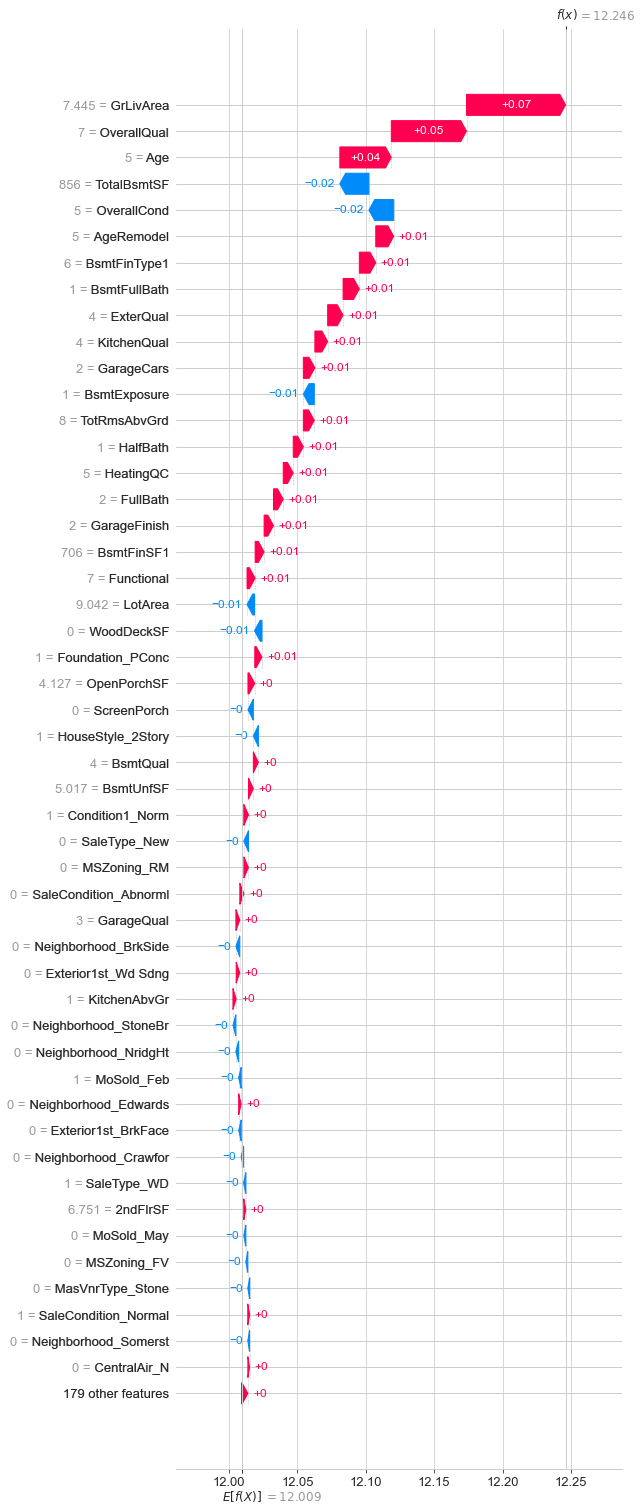

In [11]:
sreg.fit(X,y)
f = lambda x: sreg.predict(x)
explainer = shap.Explainer(f, X)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0], max_display = 50)

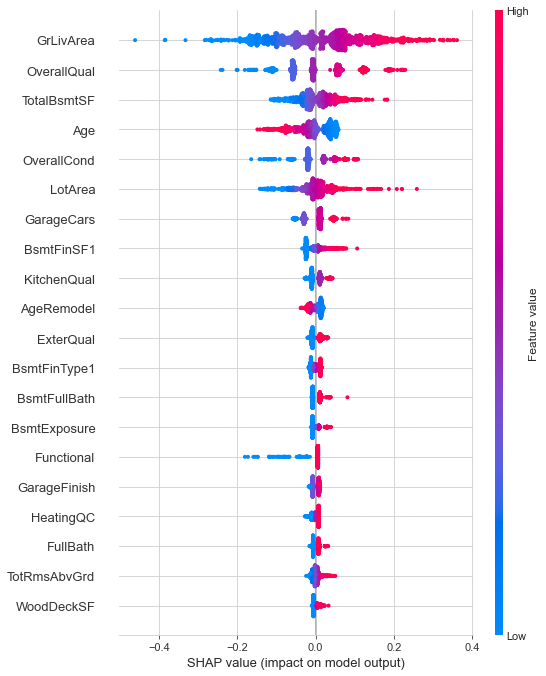

In [17]:
shap.summary_plot(shap_values, X)

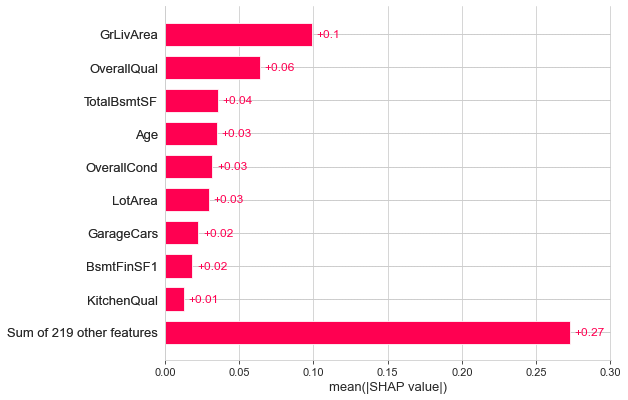

In [18]:
shap.plots.bar(shap_values)

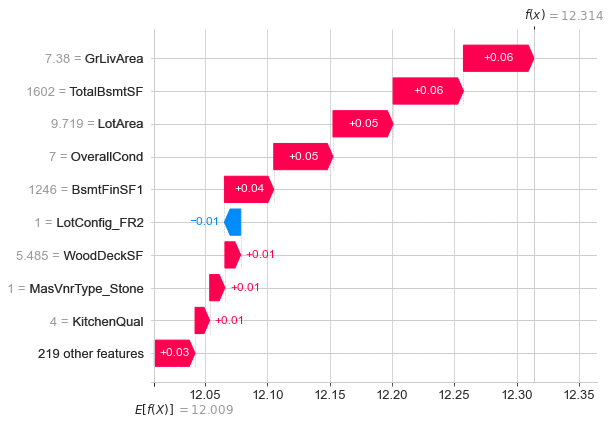

In [22]:
shap.plots.waterfall(shap_values[420])
